# MLB Salary Prediction (Part 2): EDA and Model

Click [here](./data_cleaning.ipynb) to see __Part 1: Data Wrangling__



In [1]:
from pybaseball import batting_stats
from pybaseball import playerid_lookup
from pybaseball import player_search_list
from pybaseball import playerid_reverse_lookup
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import seaborn as sns
import numpy as np
import pandas as pd
import csv
pd.set_option('display.max_rows', 10)

In [2]:
data_df = pd.read_csv('data/data_cleaned.csv')
data_df.reset_index(drop=False, inplace=True)
data_df.head()

index  IDfg             Name  Age    G    PA    AB    R    H   1B  ...  \
0      0  5677       A.J. Ellis   35  468  1713  1448  143  341  241  ...   
1      1   746  A.J. Pierzynski   36  664  2587  2424  254  682  479  ...   
2      2   746  A.J. Pierzynski   35  664  2628  2455  272  695  489  ...   
3      3   746  A.J. Pierzynski   37  628  2414  2258  222  616  431  ...   
4      4   746  A.J. Pierzynski   38  613  2347  2191  217  610  429  ...   

      ISO     OPS  wRC  wRAA  wRC+   WPA  fWAR  Year_FA     Salary  \
0  0.1164  0.6804  183  -8.4  92.8 -1.46   2.6     2017  2500000.0   
1  0.1476  0.7440  301   6.0  94.6 -2.58   8.8     2014   500000.0   
2  0.1440  0.7452  305   0.0  93.6 -2.85   9.7     2013  7500000.0   
3  0.1398  0.7180  268  -2.4  90.4 -4.54   5.3     2015  2000000.0   
4  0.1422  0.7342  274  12.1  96.6 -2.46   5.1     2016  3000000.0   

   num_seasonIncluded  
0                   5  
1                   5  
2                   5  
3                   5  
4                   5  

[5 rows x 37 columns]

## Step 1: Log transform salary data

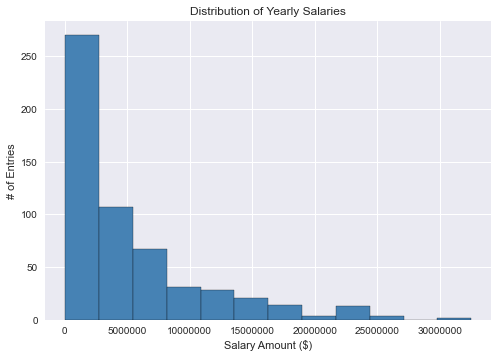

In [3]:
# inspect distribution of yearly salaries
plt.style.use('seaborn')
plt.hist(data_df['Salary'], bins=12, color='steelblue', edgecolor='black')
plt.title('Distribution of Yearly Salaries')
plt.ylabel('# of Entries')
plt.xlabel('Salary Amount ($)')
plt.ticklabel_format(axis='x', useOffset=False, style='plain')

In [4]:
# natural log salaries
data_df.insert(len(data_df.columns), 'Salary_log',np.log(data_df['Salary']))

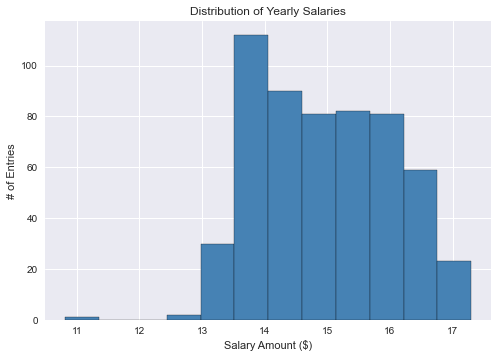

In [5]:
plt.hist(data_df['Salary_log'], bins=12, color='steelblue', edgecolor='black')
plt.title('Distribution of Yearly Salaries')
plt.ylabel('# of Entries')
plt.xlabel('Salary Amount ($)')
plt.show()

## EDA 

In [6]:
# get squared tberm of WAR

data_df['WAR2'] = data_df['fWAR'] ** 2

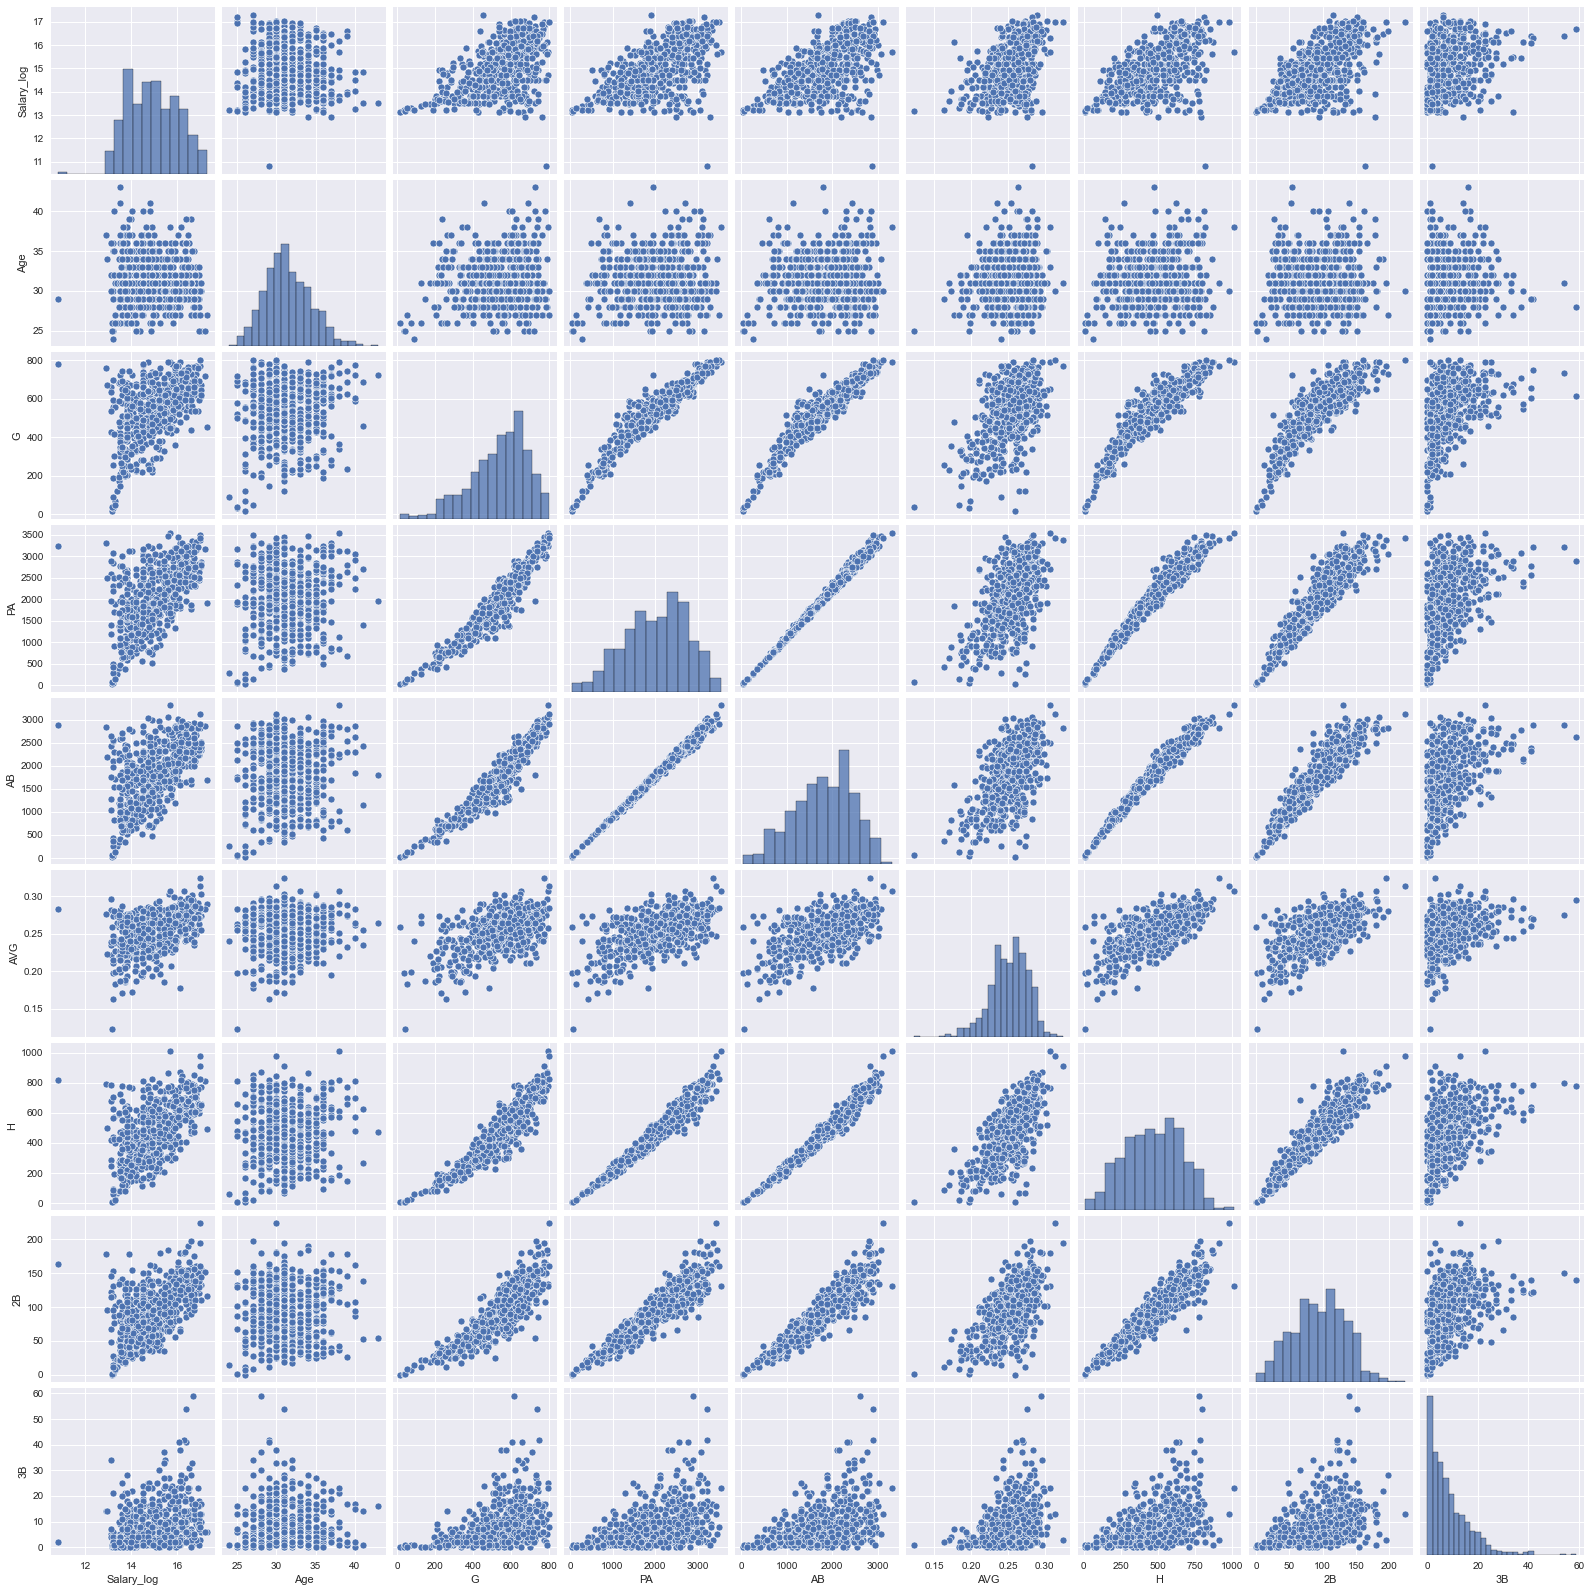

In [27]:
##break up the variables for individual plotting
plot_vars1=['Salary_log','Age','G','PA','AB', 'AVG', 'H', '2B', '3B']
plot_vars2=['Salary_log','HR','RBI','SB','CS', 'BB', 'SO', 'GDP', 'HBP']
plot_vars3=['Salary_log', 'BABIP', 'ISO', 'OPS', 'wRC', 'wRAA', 'wRC+', 'WPA', 'fWAR', 'WAR_sqrt']
plot_vars4=['Salary_log', 'HR', 'BB', 'HBP', 'IBB', 'OPS', 'wRC', 'fWAR', 'Year_FA']


sns.pairplot(data_df,vars=plot_vars1);


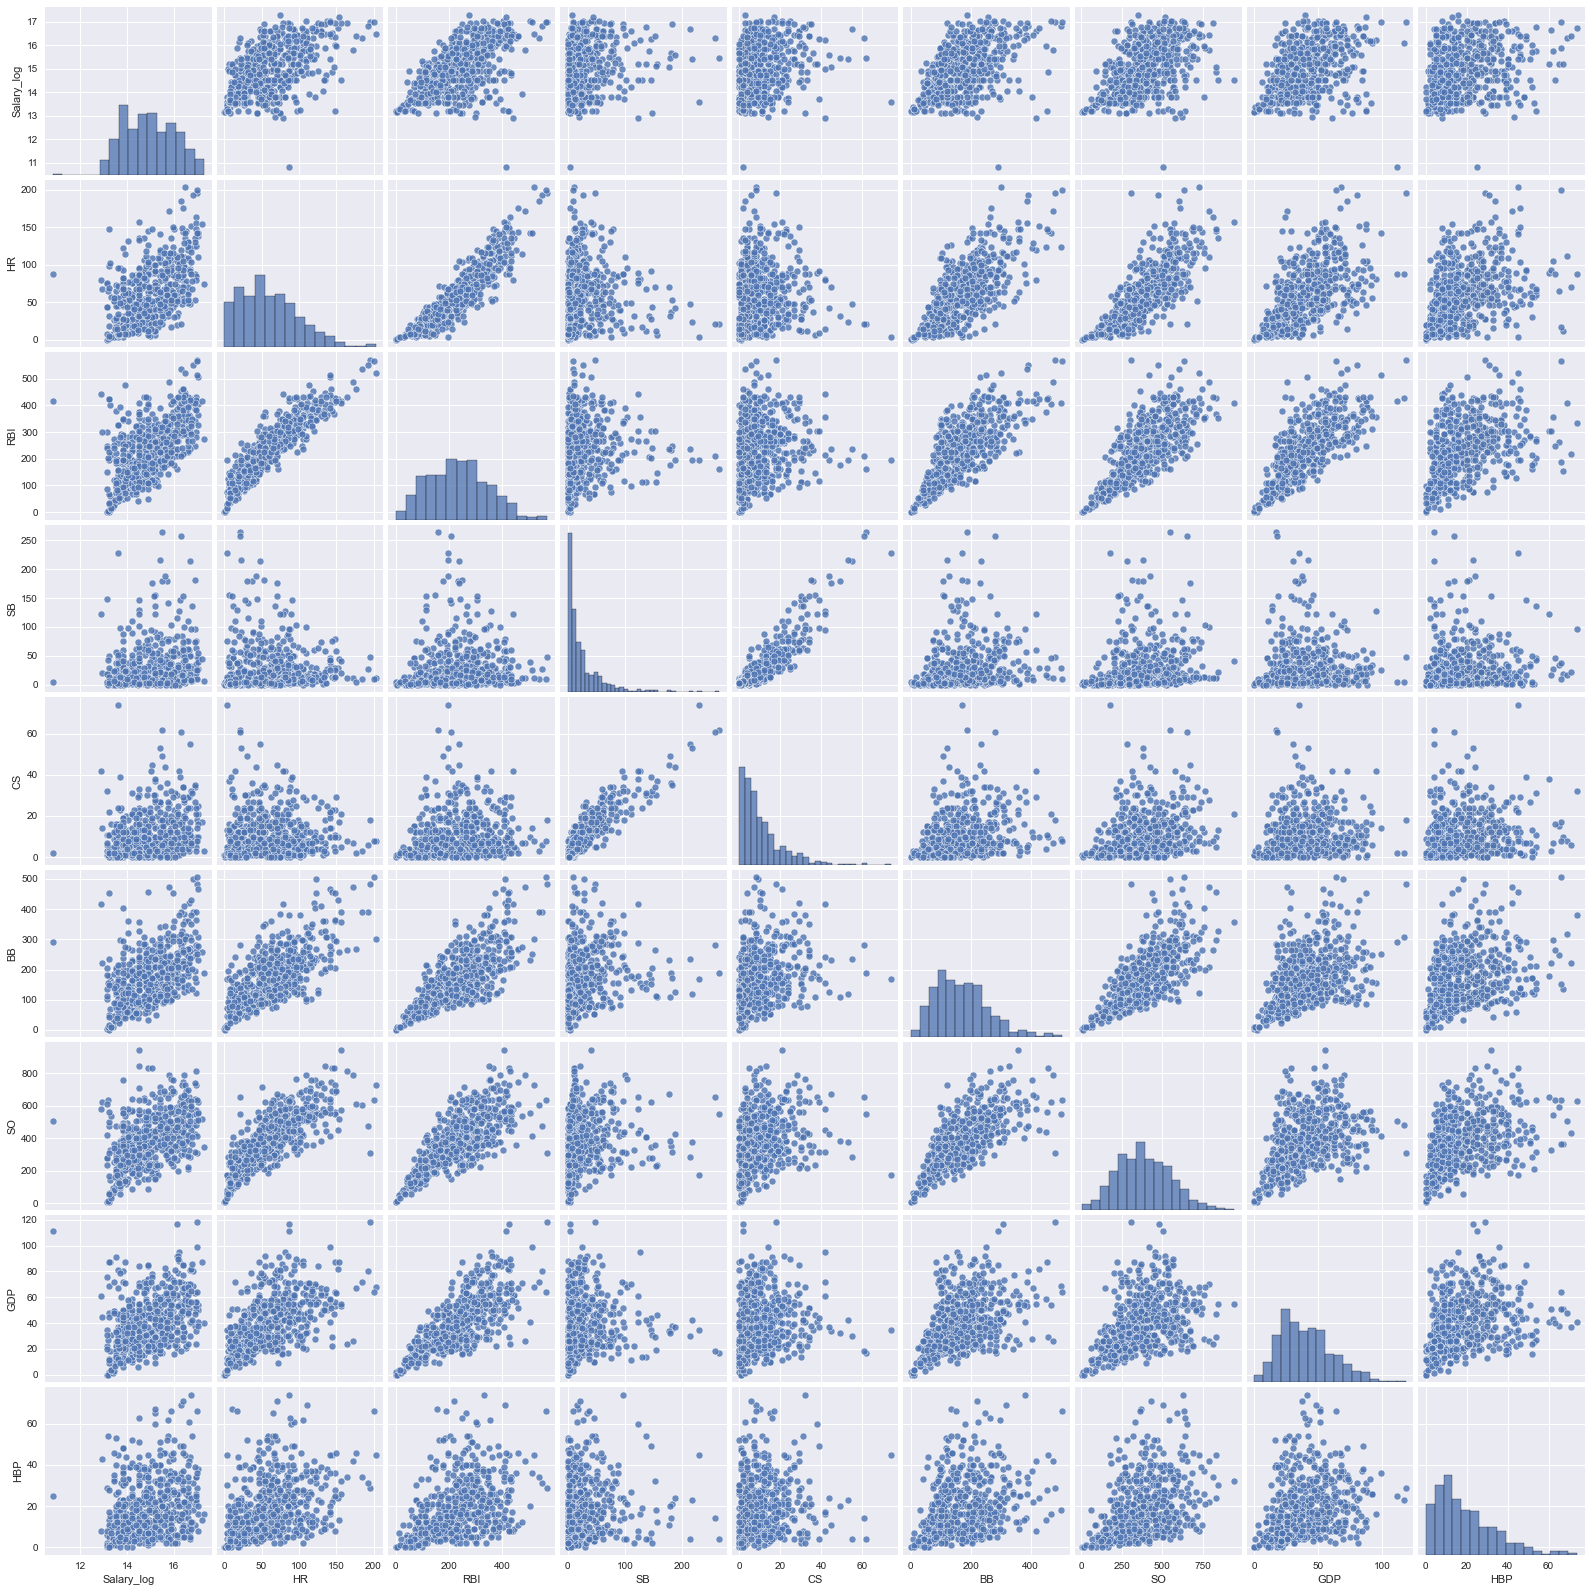

In [35]:
sns.pairplot(data_df,vars=plot_vars2, plot_kws=dict(alpha=0.8));

In [9]:
X = data_df[['Age', 'AB', 'R', 'H', '1B', 
                   'HR', 'BB', 'HBP', 'IBB', 'OPS', 
                   'wRC', 'fWAR', 'Year_FA']]
y = data_df['Salary_log']

In [10]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Salary_log   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     60.80
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           3.39e-97
Time:                        10:55:55   Log-Likelihood:                -579.42
No. Observations:                 561   AIC:                             1187.
Df Residuals:                     547   BIC:                             1247.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -40.5365     23.666     -1.713      0.0

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


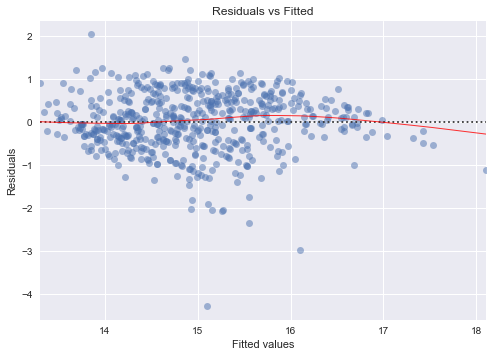

In [12]:

dataframe = pd.concat([X, y], axis=1)

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

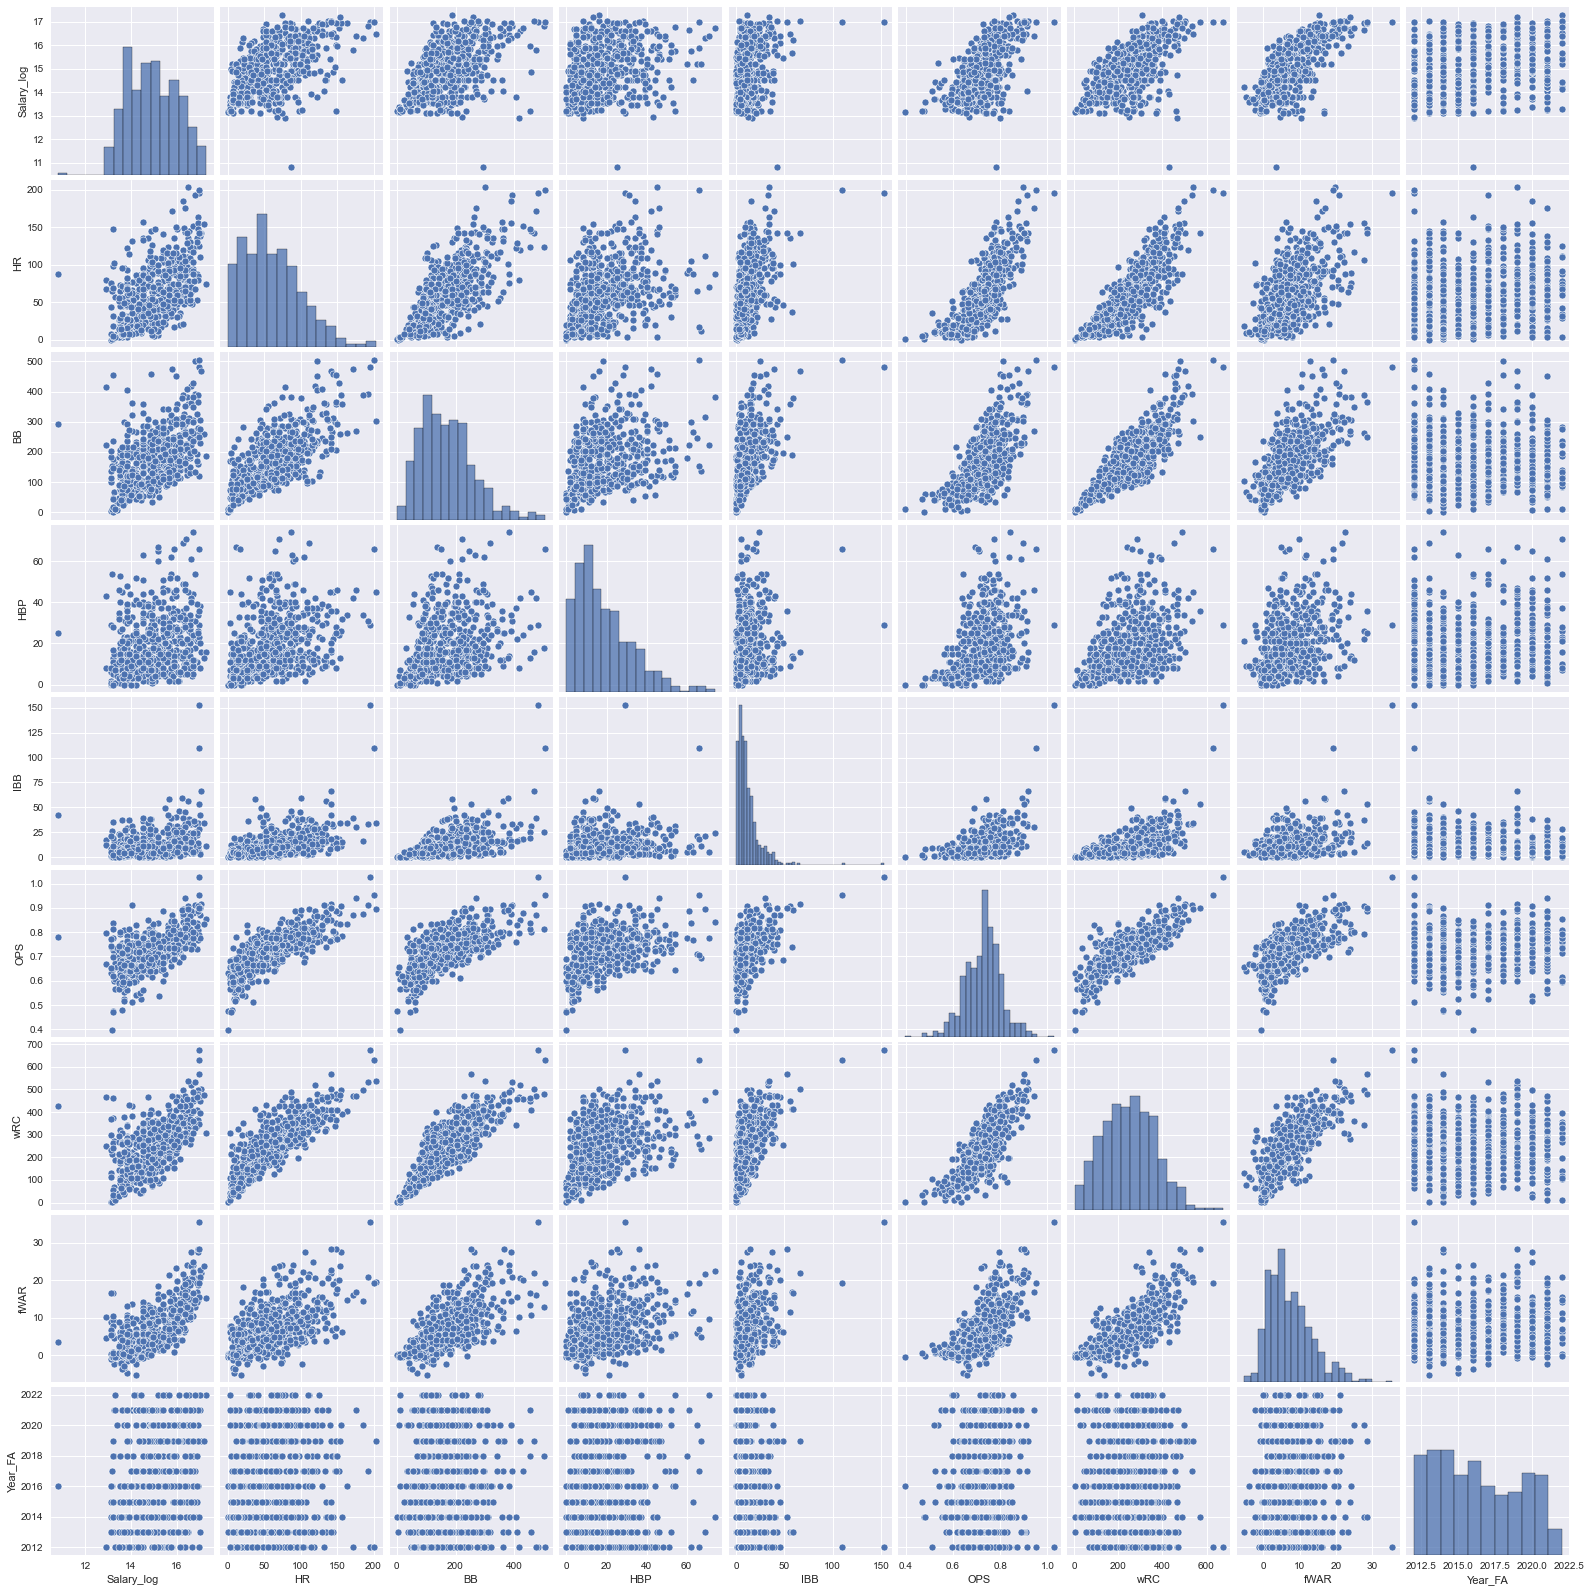

In [14]:
sns.pairplot(data_df,vars=plot_vars4);

# Check linearity of WAR 

In [17]:
X_war = data_df[['Age','HR','ISO','OPS','OBP','fWAR']]
X_war = sm.add_constant(X_war)
y = data_df['Salary_log']
model_war = sm.OLS(y, X_war)
results_war = model_war.fit()
print(results_war.summary())

                            OLS Regression Results                            
Dep. Variable:             Salary_log   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     119.1
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           2.78e-96
Time:                        11:59:33   Log-Likelihood:                -597.85
No. Observations:                 561   AIC:                             1210.
Df Residuals:                     554   BIC:                             1240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8136      0.488     28.316      0.0

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


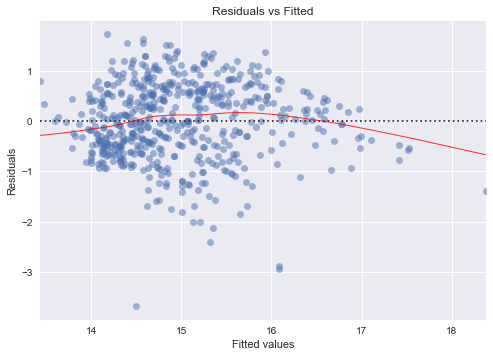

In [16]:

df_war = pd.concat([X_war, y], axis=1)

# model values
model_fitted_y = results_war.fittedvalues
# model residuals
model_residuals = results_war.resid
# normalized residuals
model_norm_residuals = results_war.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results_war.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results_war.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=df_war,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = model_war.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[267.2364781227089,
 1.0386405249211779,
 5.0427830196483505,
 8.595404988281121,
 18.430268772809427,
 8.039311481660757,
 2.134053900413673]